In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model


In [2]:

# Insert MLflow tracking setup here
import mlflow
import mlflow.keras

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('Lympho-Detection-Attention')

<Experiment: artifact_location='mlflow-artifacts:/390491310013789626', creation_time=1715773614965, experiment_id='390491310013789626', last_update_time=1715773614965, lifecycle_stage='active', name='Lympho-Detection-Attention', tags={}>

In [3]:
files=[]
paths = []
for dirname, _, filenames in os.walk('Original/Pro'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        files.append(filename)

In [4]:
mpaths = []
for dirname, _, filenames in os.walk('Segmented/Pro'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        mpaths.append(path)

In [5]:
df0=pd.DataFrame(columns=['file','path','mpath'])
df0['file']=sorted(files)
df0['path']=sorted(paths)
df0['mpath']=sorted(mpaths)
display(df0)
df=df0.iloc[0:len(df0)//2]
test_df=df0.iloc[len(df0)//2:]

file                                    path  \
0    WBC-Malignant-Pro-001.jpg  Original/Pro/WBC-Malignant-Pro-001.jpg   
1    WBC-Malignant-Pro-002.jpg  Original/Pro/WBC-Malignant-Pro-002.jpg   
2    WBC-Malignant-Pro-003.jpg  Original/Pro/WBC-Malignant-Pro-003.jpg   
3    WBC-Malignant-Pro-004.jpg  Original/Pro/WBC-Malignant-Pro-004.jpg   
4    WBC-Malignant-Pro-005.jpg  Original/Pro/WBC-Malignant-Pro-005.jpg   
..                         ...                                     ...   
799  WBC-Malignant-Pro-800.jpg  Original/Pro/WBC-Malignant-Pro-800.jpg   
800  WBC-Malignant-Pro-801.jpg  Original/Pro/WBC-Malignant-Pro-801.jpg   
801  WBC-Malignant-Pro-802.jpg  Original/Pro/WBC-Malignant-Pro-802.jpg   
802  WBC-Malignant-Pro-803.jpg  Original/Pro/WBC-Malignant-Pro-803.jpg   
803  WBC-Malignant-Pro-804.jpg  Original/Pro/WBC-Malignant-Pro-804.jpg   

                                       mpath  
0    Segmented/Pro/WBC-Malignant-Pro-001.jpg  
1    Segmented/Pro/WBC-Malignant-Pro-002.jpg  
2    Segmented/Pro/WBC-Malignant-Pro-003.jpg  
3    Segmented/Pro/WBC-Malignant-Pro-004.jpg  
4    Segmented/Pro/WBC-Malignant-Pro-005.jpg  
..                                       ...  
799  Segmented/Pro/WBC-Malignant-Pro-800.jpg  
800  Segmented/Pro/WBC-Malignant-Pro-801.jpg  
801  Segmented/Pro/WBC-Malignant-Pro-802.jpg  
802  Segmented/Pro/WBC-Malignant-Pro-803.jpg  
803  Segmented/Pro/WBC-Malignant-Pro-804.jpg  

[804 rows x 3 columns]

In [6]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [7]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

In [8]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
# Define a custom callback to print and log metrics during training
class PrintAndLogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            for metric, value in logs.items():
                print(f"{self.model_name} - Epoch {epoch + 1}: {metric} = {value}")
                mlflow.log_metric(f"{self.model_name}_{metric}", value, step=epoch)

In [11]:
# Define the U-Net model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(output_channels):
    inputs = Input(shape=(256, 256, 3))

    # Downsampling through the model
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)

    # Upsampling
    u1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, c4])
    u2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, c3])
    u3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u2)
    u3 = concatenate([u3, c2])
    u4 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(u3)
    u4 = concatenate([u4, c1])

    # Output layer
    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(u4)

    model = Model(inputs=inputs, outputs=outputs)
    return model



# Define different models here (Insert new model definitions or ensure they are defined before this block)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.models import Model

def build_simplified_cnn():
    inputs = Input(shape=(256, 256, 3))
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder to match the output size of 256x256
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    
    # Final output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

def build_densenet_based_model():
    base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3), weights='imagenet')
    x = base_model.output

    # Adding upsampling layers
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 16x16
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 32x32
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 64x64
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 128x128
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 256x256

    # Final output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)  # Ensure single channel output

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

from tensorflow.keras.layers import Multiply, Add, Activation, concatenate

def attention_block(g, x, filters):
    """ Attention mechanism to focus on important features """
    theta_x = Conv2D(filters, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(filters, (1, 1), padding='same')(g)
    concat_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(sigmoid_xg)
    return Multiply()([x, shape_up])

def build_attention_unet(output_channels):
    inputs = Input(shape=(256, 256, 3))
    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    bn = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    # Upsampling with attention
    a1 = attention_block(bn, c2, 32)
    u1 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, a1])
    a2 = attention_block(u1, c1, 16)
    u2 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, a2])
    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(u2)
    model = Model(inputs, outputs)
    return model

from tensorflow.keras.applications import ResNet50

def build_resnet_unet(output_channels):
    base_model = ResNet50(include_top=False, input_shape=(256, 256, 3), weights='imagenet')
    # Start from the last layer of ResNet50
    x = base_model.output

    # Upsampling to the original image size
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Now 16x16
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Now 32x32
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Now 64x64
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Now 128x128
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)   # Now 256x256

    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid', padding='same')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

In [13]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)

EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [15]:
# Calculate the number of training examples
TRAIN_LENGTH = len(train_df)  # Ensure you have defined train_df correctly
BATCH_SIZE = 16  # or whatever batch size you are using

# Calculate steps per epoch
steps_per_epoch = TRAIN_LENGTH // BATCH_SIZE

# Calculate the number of validation examples
VALIDATION_LENGTH = len(valid_df)  # Ensure you have defined valid_df correctly

# Calculate validation steps
validation_steps = VALIDATION_LENGTH // BATCH_SIZE


In [16]:
def log_metrics(history, metrics):
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        for metric in metrics:
            mlflow.log_metric(f"train_{metric}", history.history[metric][epoch], step=epoch)
            mlflow.log_metric(f"val_{metric}", history.history[f"val_{metric}"][epoch], step=epoch)

# MLflow tracking for experiments with different model architectures
print('1')
with mlflow.start_run(run_name='ALL Experiments only cross entropy 2'):
    print('2')

    # Nested run for the U-Net model
    with mlflow.start_run(nested=True, run_name='U-Net Model'):
        print('3')
        unet_model = build_unet_model(1)
        print('4')
        unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print('5')
        history = unet_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                       validation_data=valid_dataset, validation_steps=validation_steps,
                       callbacks=[early_stop])
        print('6')
        mlflow.log_param("model_type", "U-Net")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])
        
        # Evaluate on the test set
        test_loss, test_accuracy = unet_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        mlflow.keras.log_model(unet_model, 'unet_model')
        print('7')

    # Nested run for the Simplified CNN model
    with mlflow.start_run(nested=True, run_name='Simplified CNN Model'):
        print('8')
        cnn_model = build_simplified_cnn()
        print('9')
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print('10')
        history = cnn_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                      validation_data=valid_dataset, validation_steps=validation_steps)
        print('11')
        mlflow.log_param("model_type", "Simplified CNN")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])
        
        # Evaluate on the test set
        test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        mlflow.keras.log_model(cnn_model, 'simplified_cnn_model')
        print('12')

    # Nested run for the DenseNet-based model
    with mlflow.start_run(nested=True, run_name='DenseNet-based Model'):
        print('13')
        densenet_model = build_densenet_based_model()
        print('14')
        densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print('15')
        history = densenet_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                           validation_data=valid_dataset, validation_steps=validation_steps)
        print('16')
        mlflow.log_param("model_type", "DenseNet-based")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])
        
        # Evaluate on the test set
        test_loss, test_accuracy = densenet_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        mlflow.keras.log_model(densenet_model, 'densenet_based_model')
        print('17')

        # Nested run for the Attention U-Net model
    # Nested run for the Attention U-Net model
    with mlflow.start_run(nested=True, run_name='Attention U-Net Model'):
        print('Attention U-Net Model Training...')
        attention_unet_model = build_attention_unet(1)
        attention_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = attention_unet_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                                           validation_data=valid_dataset, validation_steps=validation_steps)
        print('Logging parameters and metrics...')
        mlflow.log_param("model_type", "Attention U-Net")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])

        # Evaluate on the test set
        test_loss, test_accuracy = attention_unet_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)

        mlflow.keras.log_model(attention_unet_model, 'attention_unet_model')

    # Nested run for the ResNet-based U-Net model
    with mlflow.start_run(nested=True, run_name='ResNet-based U-Net Model'):
        print('ResNet-based U-Net Model Training...')
        resnet_unet_model = build_resnet_unet(1)
        resnet_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = resnet_unet_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                                        validation_data=valid_dataset, validation_steps=validation_steps)
        print('Logging parameters and metrics...')
        mlflow.log_param("model_type", "ResNet-based U-Net")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])

        # Evaluate on the test set
        test_loss, test_accuracy = resnet_unet_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)

        mlflow.keras.log_model(resnet_unet_model, 'resnet_unet_model')


1
2
3
4
5
Epoch 1/30
18/18 [==============================] - 4s 149ms/step - loss: 0.4176 - accuracy: 0.8733 - val_loss: 0.3801 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 3s 139ms/step - loss: 0.3682 - accuracy: 0.8721 - val_loss: 0.3674 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 2s 137ms/step - loss: 0.3625 - accuracy: 0.8696 - val_loss: 0.3945 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 2s 136ms/step - loss: 0.3747 - accuracy: 0.8711 - val_loss: 0.3711 - val_accuracy: 0.8699
Epoch 5/30
18/18 [==============================] - 2s 138ms/step - loss: 0.3532 - accuracy: 0.8771 - val_loss: 0.3615 - val_accuracy: 0.8699
Epoch 6/30
18/18 [==============================] - 2s 138ms/step - loss: 0.3503 - accuracy: 0.8715 - val_loss: 0.3282 - val_accuracy: 0.8724
Epoch 7/30
18/18 [==============================] - 2s 137ms/step - loss: 0.3347 - accuracy: 0.8760 - val_loss: 0.3268 - val_accuracy: 0.8

2024/05/15 18:06:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmp0wpgfi5q/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmp0wpgfi5q/model/data/model/assets
/Users/vishalvignesh/miniforge3/envs/tensorflow/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


7
8
9
10
Epoch 1/30
18/18 [==============================] - 2s 84ms/step - loss: 0.4960 - accuracy: 0.8602 - val_loss: 0.3920 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 1s 76ms/step - loss: 0.3829 - accuracy: 0.8725 - val_loss: 0.3791 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 1s 76ms/step - loss: 0.3666 - accuracy: 0.8750 - val_loss: 0.3717 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 1s 76ms/step - loss: 0.3656 - accuracy: 0.8735 - val_loss: 0.3664 - val_accuracy: 0.8699
Epoch 5/30
18/18 [==============================] - 1s 75ms/step - loss: 0.3594 - accuracy: 0.8721 - val_loss: 0.3570 - val_accuracy: 0.8699
Epoch 6/30
18/18 [==============================] - 1s 82ms/step - loss: 0.3475 - accuracy: 0.8700 - val_loss: 0.3355 - val_accuracy: 0.8699
Epoch 7/30
18/18 [==============================] - 1s 79ms/step - loss: 0.3236 - accuracy: 0.8766 - val_loss: 0.3206 - val_accuracy: 0.8699
Epoc

2024/05/15 18:07:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpd7q_w86_/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpd7q_w86_/model/data/model/assets


12
13
14
15
Epoch 1/30
18/18 [==============================] - 21s 455ms/step - loss: 0.4369 - accuracy: 0.8353 - val_loss: 1.2579 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 10s 308ms/step - loss: 0.2778 - accuracy: 0.8740 - val_loss: 0.8106 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 5s 304ms/step - loss: 0.2558 - accuracy: 0.8733 - val_loss: 1.4730 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 6s 308ms/step - loss: 0.2427 - accuracy: 0.8719 - val_loss: 0.9104 - val_accuracy: 0.8699
Epoch 5/30
18/18 [==============================] - 5s 305ms/step - loss: 0.2288 - accuracy: 0.8779 - val_loss: 0.7545 - val_accuracy: 0.8699
Epoch 6/30
18/18 [==============================] - 5s 306ms/step - loss: 0.2346 - accuracy: 0.8694 - val_loss: 0.6850 - val_accuracy: 0.8699
Epoch 7/30
18/18 [==============================] - 5s 306ms/step - loss: 0.2331 - accuracy: 0.8723 - val_loss: 1.0777 - val_accuracy:

2024/05/15 18:10:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmp2ove330_/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmp2ove330_/model/data/model/assets


17
Attention U-Net Model Training...
Epoch 1/30
18/18 [==============================] - 5s 114ms/step - loss: 0.5026 - accuracy: 0.8463 - val_loss: 0.3851 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 2s 104ms/step - loss: 0.3743 - accuracy: 0.8723 - val_loss: 0.3726 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 2s 98ms/step - loss: 0.3611 - accuracy: 0.8750 - val_loss: 0.3677 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 2s 118ms/step - loss: 0.3565 - accuracy: 0.8707 - val_loss: 0.3559 - val_accuracy: 0.8702
Epoch 5/30
18/18 [==============================] - 2s 105ms/step - loss: 0.3333 - accuracy: 0.8758 - val_loss: 0.3362 - val_accuracy: 0.8742
Epoch 6/30
18/18 [==============================] - 2s 94ms/step - loss: 0.3172 - accuracy: 0.8782 - val_loss: 0.3124 - val_accuracy: 0.8739
Epoch 7/30
18/18 [==============================] - 2s 92ms/step - loss: 0.2977 - accuracy: 0.8810 - val_loss: 0.

2024/05/15 18:12:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpwhj9nodd/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpwhj9nodd/model/data/model/assets


ResNet-based U-Net Model Training...
Epoch 1/30
18/18 [==============================] - 14s 297ms/step - loss: 0.4011 - accuracy: 0.8482 - val_loss: 0.5686 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 6s 216ms/step - loss: 0.2686 - accuracy: 0.8747 - val_loss: 0.4858 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 4s 214ms/step - loss: 0.2405 - accuracy: 0.8763 - val_loss: 0.6141 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 4s 214ms/step - loss: 0.2487 - accuracy: 0.8668 - val_loss: 0.8253 - val_accuracy: 0.8699
Epoch 5/30
18/18 [==============================] - 4s 214ms/step - loss: 0.2128 - accuracy: 0.8801 - val_loss: 0.9251 - val_accuracy: 0.8699
Epoch 6/30
18/18 [==============================] - 4s 214ms/step - loss: 0.2151 - accuracy: 0.8731 - val_loss: 0.6391 - val_accuracy: 0.8699
Epoch 7/30
18/18 [==============================] - 4s 215ms/step - loss: 0.2121 - accuracy: 0.8859 - val_loss

2024/05/15 18:15:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmp39qtb44r/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmp39qtb44r/model/data/model/assets


1/1 [==============================] - 4s 4s/step


ValueError: num must be an integer with 1 <= num <= 15, not 16

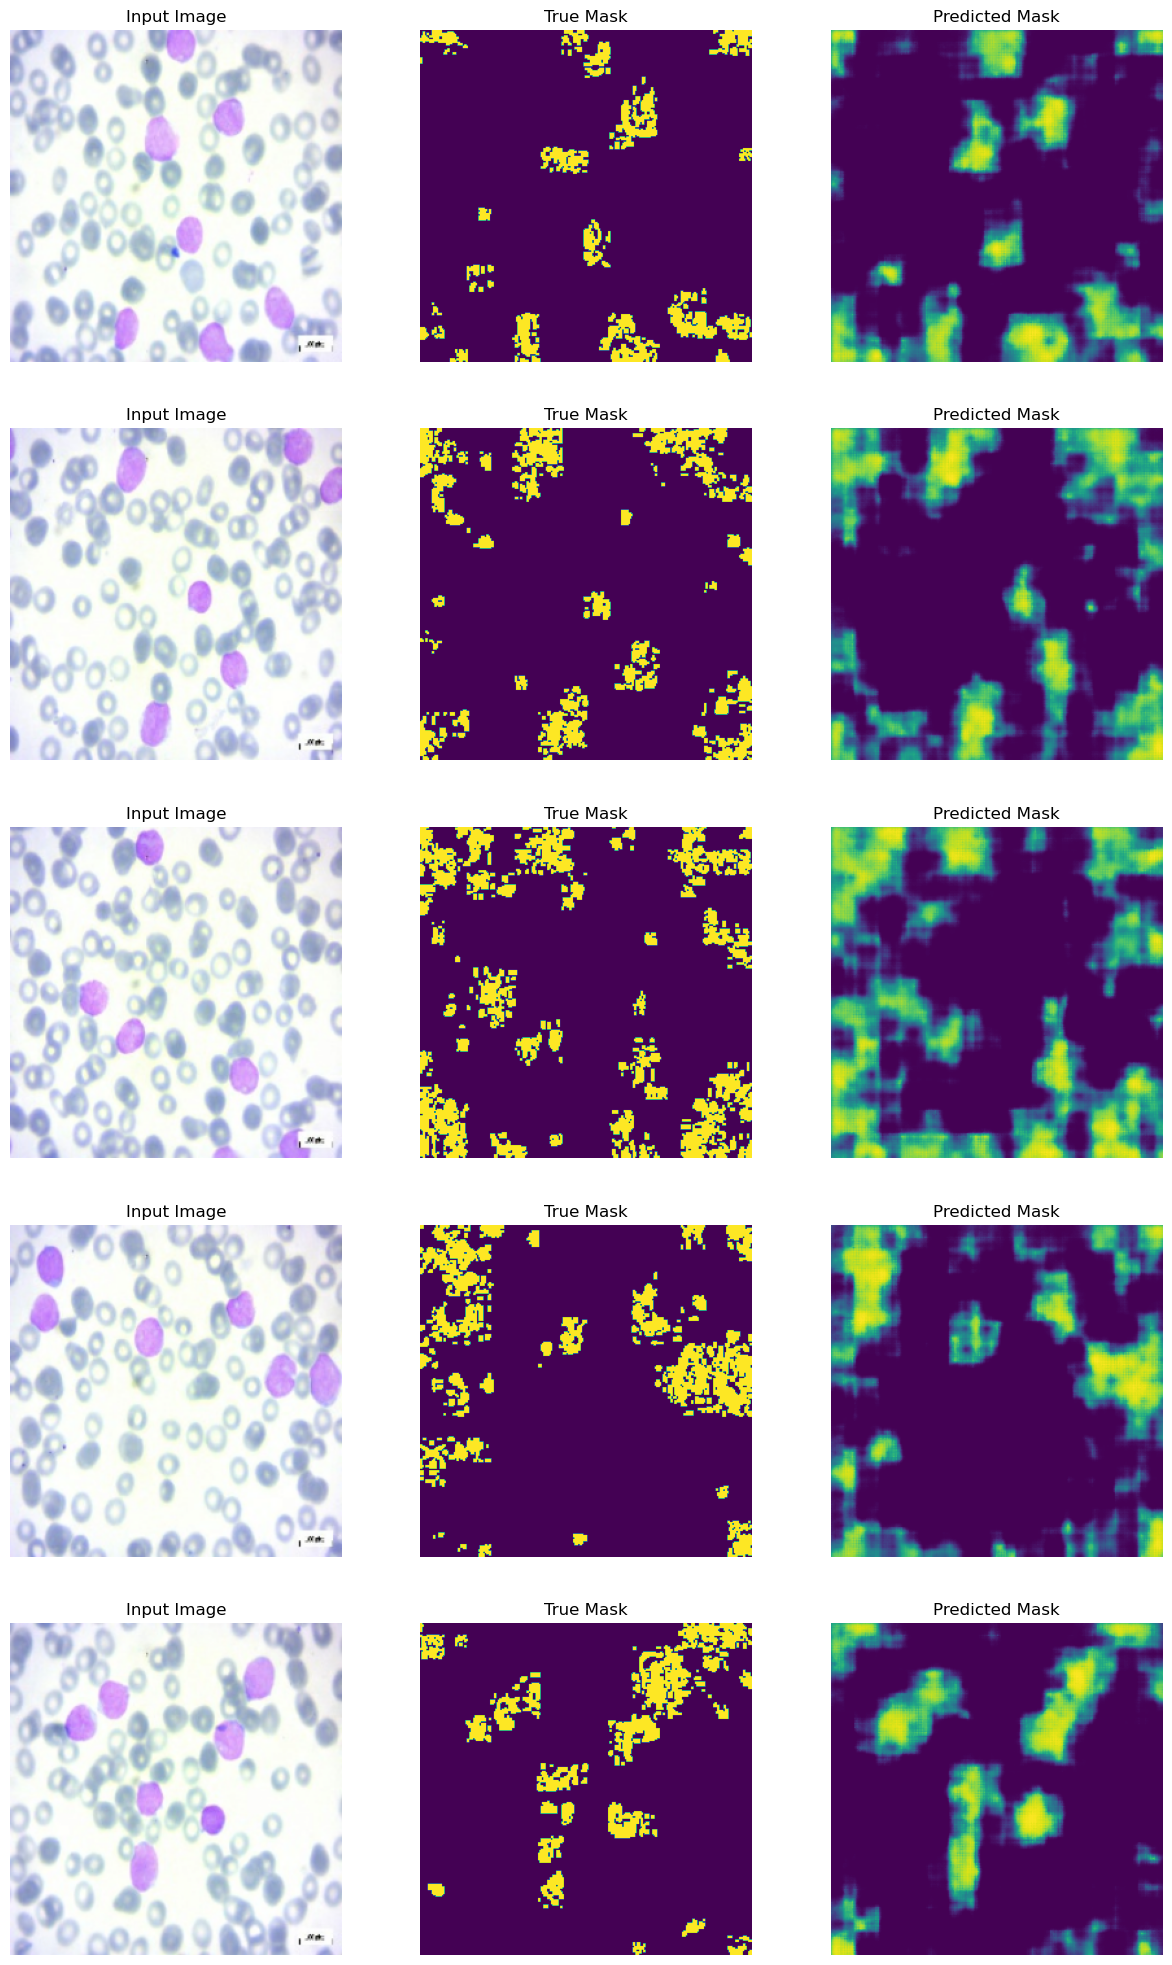

In [17]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    # Loop over images and masks directly taken from the dataset
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Predict the mask directly using batched images
        pred_masks = model.predict(images)
        
        for j in range(len(images)):
            plt.subplot(num_samples, 3, 3 * i + 1)
            plt.title("Input Image")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 2)
            plt.title("True Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(masks[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_masks[j]))
            plt.axis("off")

            # Increment i to move to the next set of subplots
            i += 1
    
    plt.tight_layout()
    plt.show()

# Example usage with your model and dataset
display_sample_predictions(densenet_model, test_dataset, num_samples=5)


1/1 [==============================] - 0s 197ms/step


ValueError: num must be an integer with 1 <= num <= 15, not 16

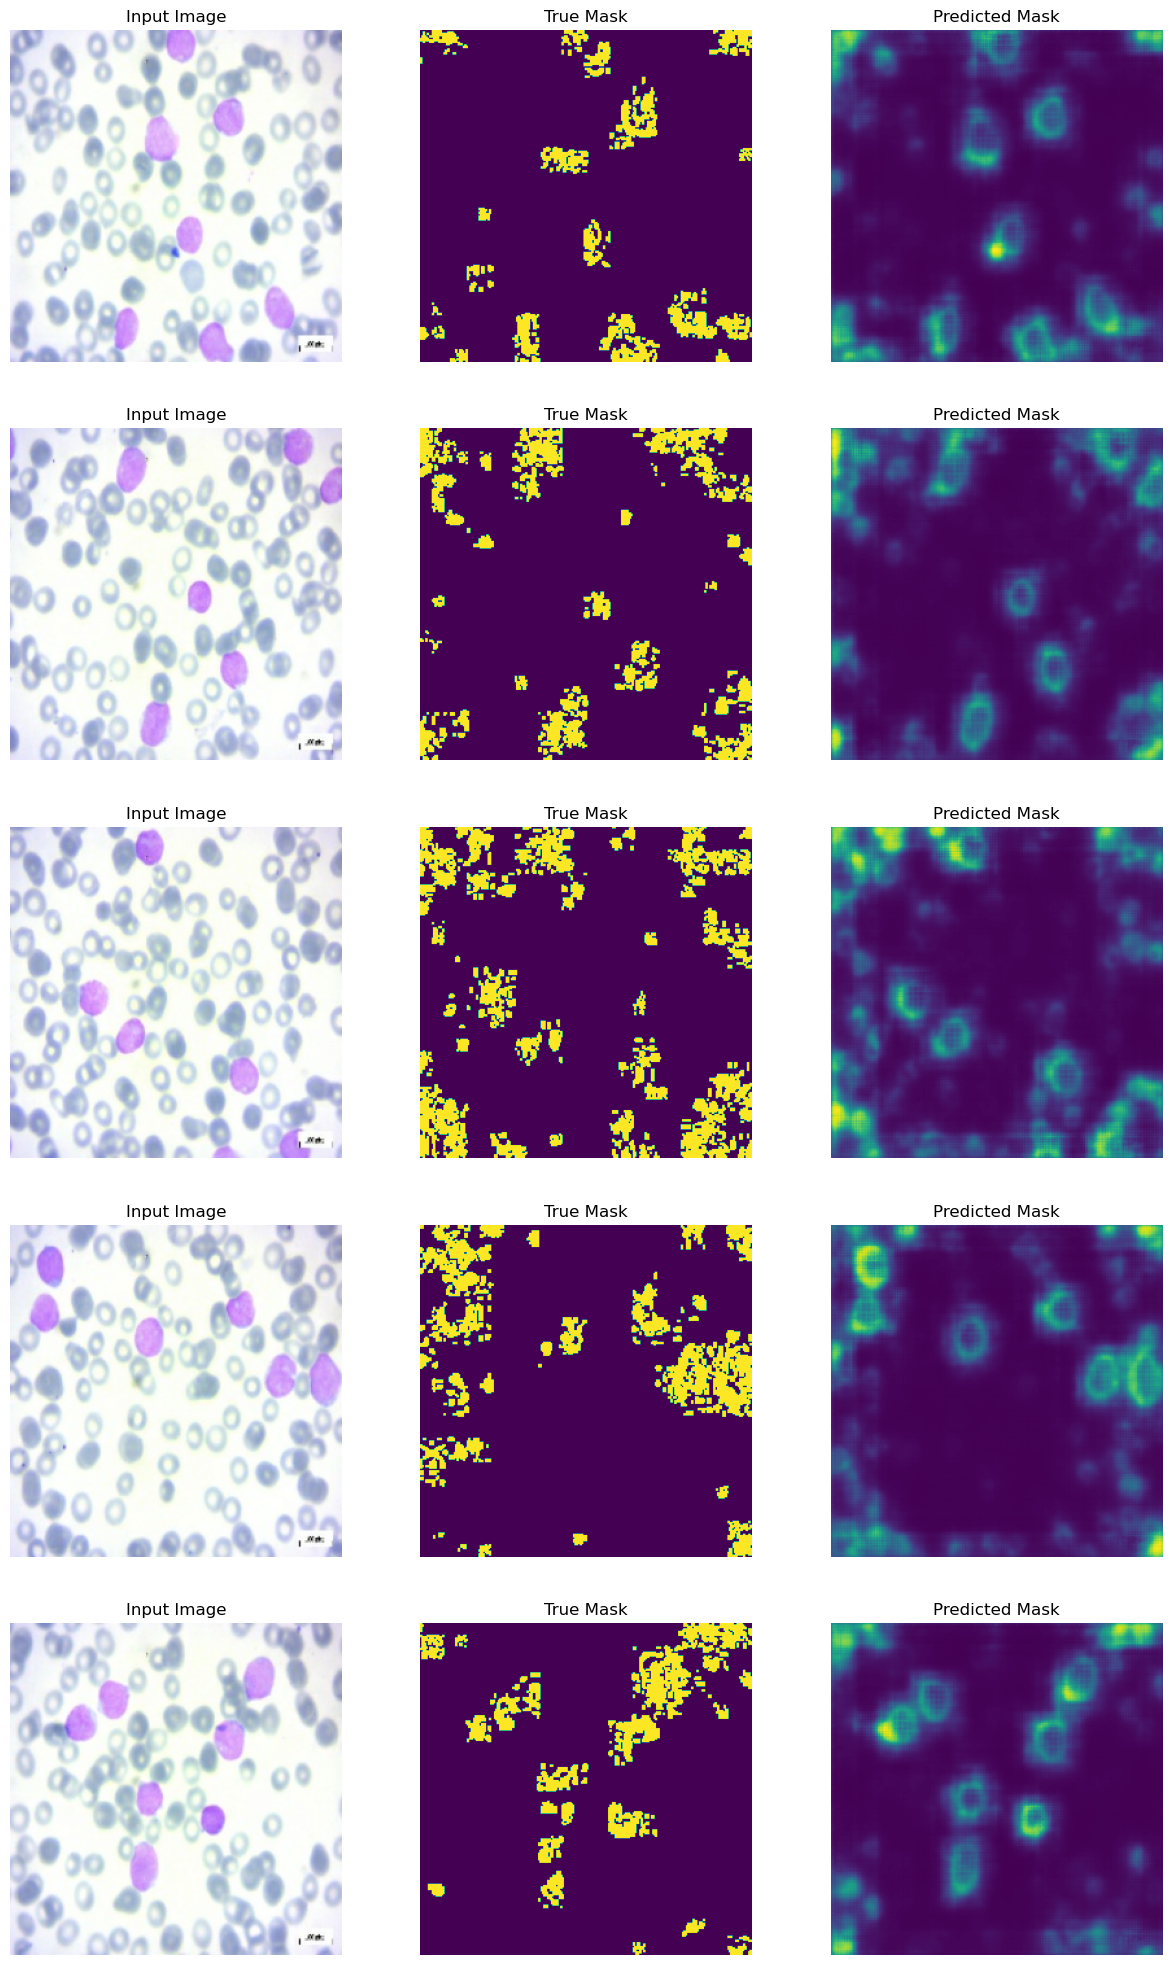

In [18]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    # Loop over images and masks directly taken from the dataset
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Predict the mask directly using batched images
        pred_masks = model.predict(images)
        
        for j in range(len(images)):
            plt.subplot(num_samples, 3, 3 * i + 1)
            plt.title("Input Image")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 2)
            plt.title("True Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(masks[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_masks[j]))
            plt.axis("off")

            # Increment i to move to the next set of subplots
            i += 1
    
    plt.tight_layout()
    plt.show()

# Example usage with your model and dataset
display_sample_predictions(unet_model, test_dataset, num_samples=5)


1/1 [==============================] - 1s 1s/step


ValueError: num must be an integer with 1 <= num <= 15, not 16

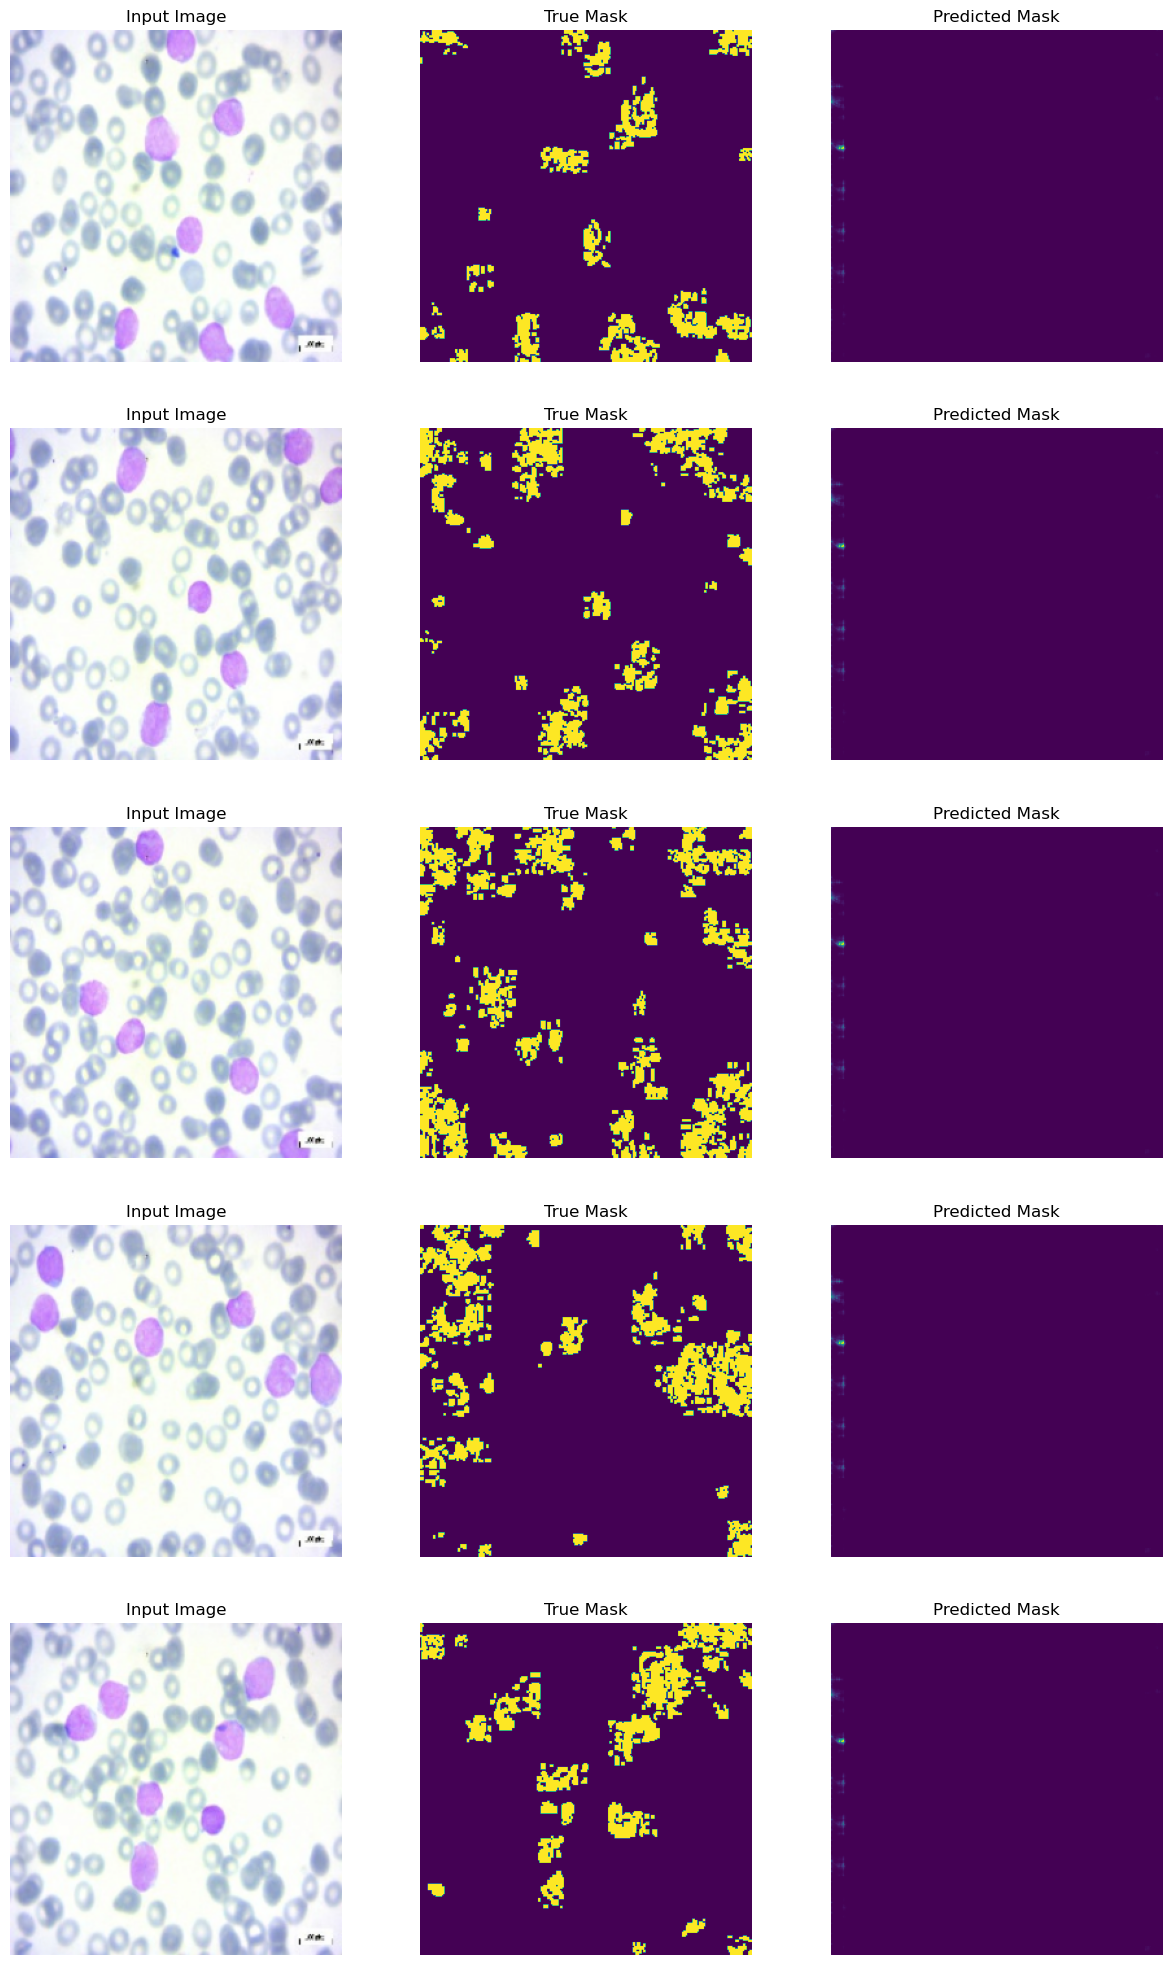

In [19]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    # Loop over images and masks directly taken from the dataset
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Predict the mask directly using batched images
        pred_masks = model.predict(images)
        
        for j in range(len(images)):
            plt.subplot(num_samples, 3, 3 * i + 1)
            plt.title("Input Image")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 2)
            plt.title("True Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(masks[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_masks[j]))
            plt.axis("off")

            # Increment i to move to the next set of subplots
            i += 1
    
    plt.tight_layout()
    plt.show()

# Example usage with your model and dataset
display_sample_predictions(resnet_unet_model, test_dataset, num_samples=5)


1/1 [==============================] - 0s 379ms/step


ValueError: num must be an integer with 1 <= num <= 15, not 16

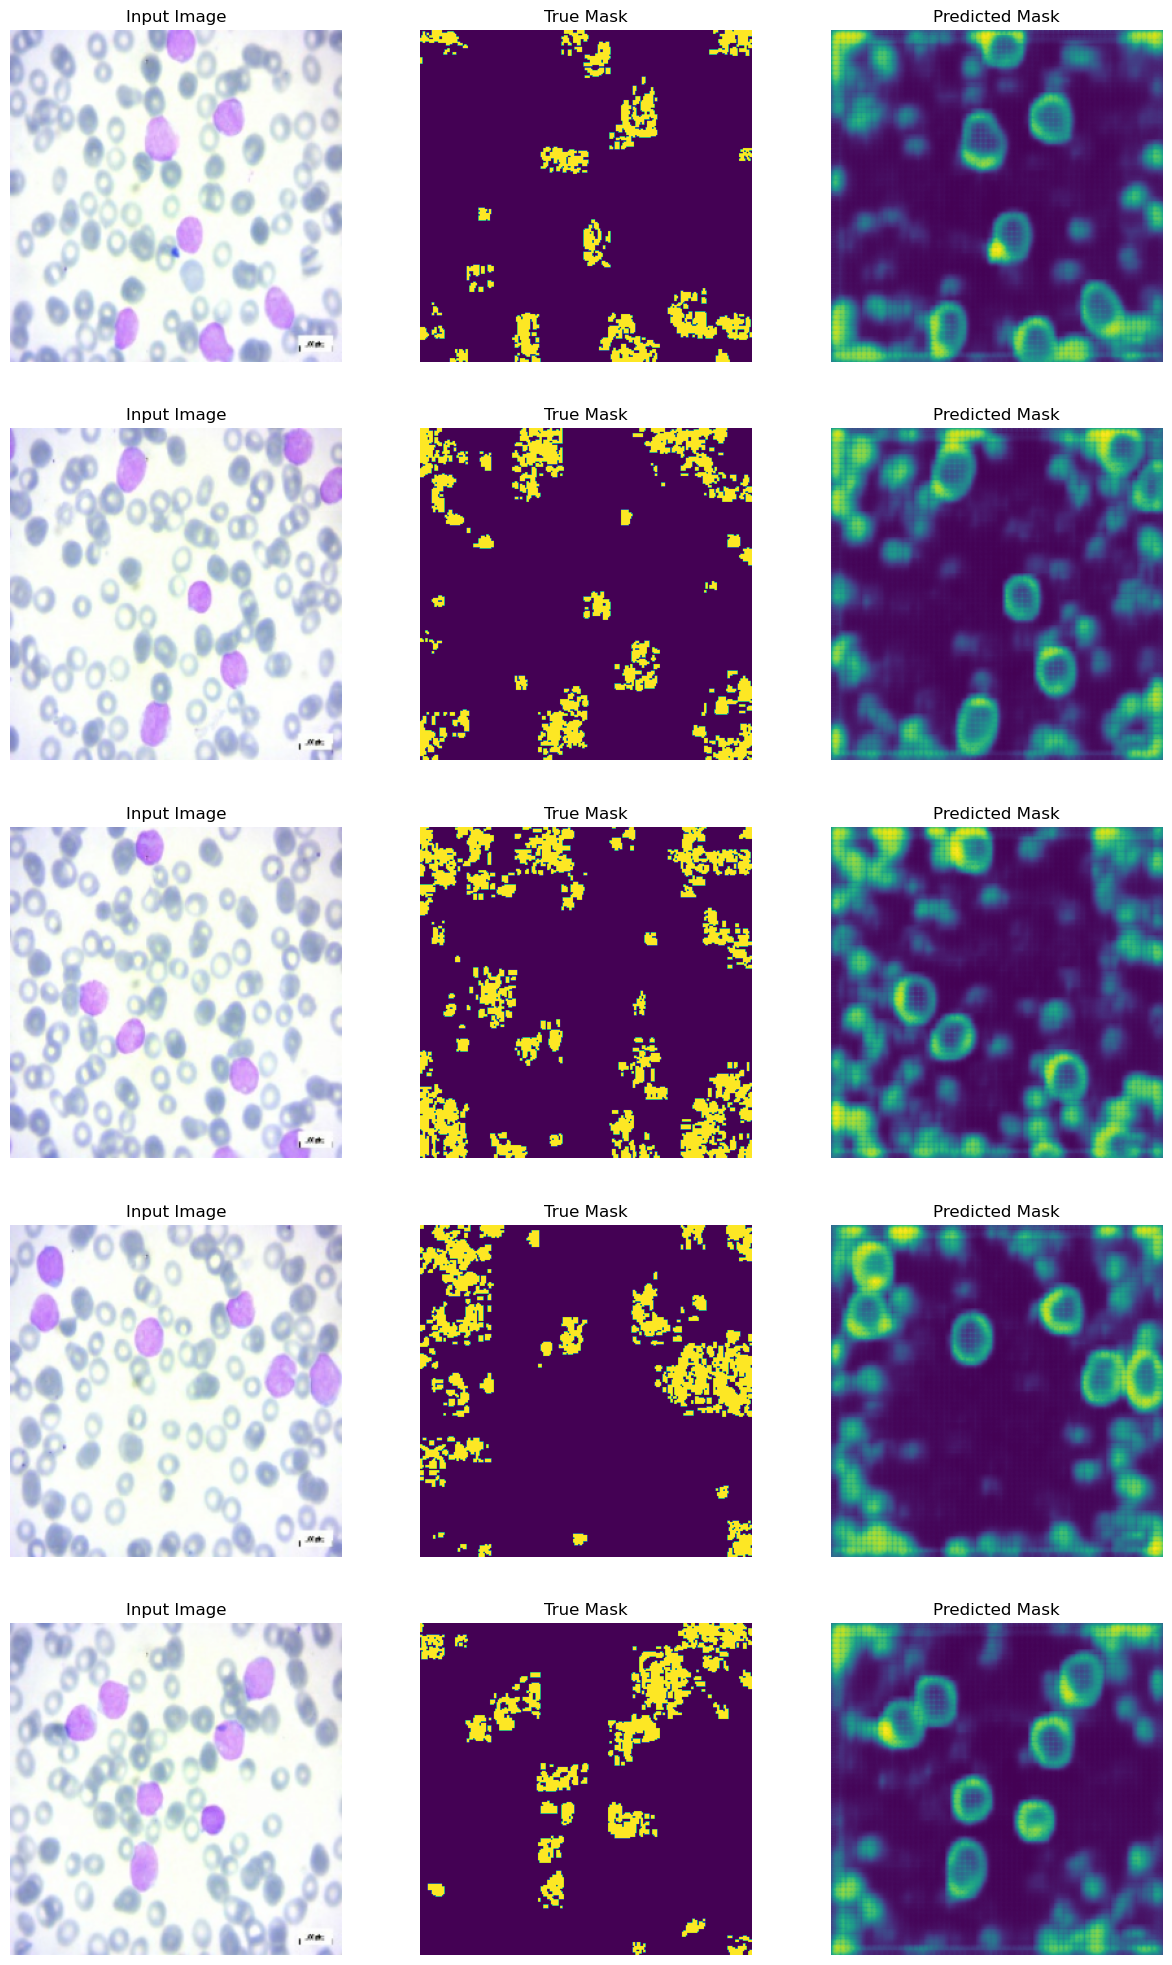

In [20]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    # Loop over images and masks directly taken from the dataset
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Predict the mask directly using batched images
        pred_masks = model.predict(images)
        
        for j in range(len(images)):
            plt.subplot(num_samples, 3, 3 * i + 1)
            plt.title("Input Image")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 2)
            plt.title("True Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(masks[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_masks[j]))
            plt.axis("off")

            # Increment i to move to the next set of subplots
            i += 1
    
    plt.tight_layout()
    plt.show()

# Example usage with your model and dataset
display_sample_predictions(attention_unet_model, test_dataset, num_samples=5)


In [ ]:
# Save the DenseNet model weights
densenet_model.save_weights('densenet_weights.h5')